In [1]:
from glob import glob
from PIL import Image
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import scipy
import sklearn
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split,KFold
import matplotlib.pyplot as plt
import seaborn as sns
import time
import operator
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,fbeta_score,make_scorer,mutual_info_score,silhouette_score,normalized_mutual_info_score,classification_report, confusion_matrix,f1_score, mean_squared_error, adjusted_rand_score
import time 
from sklearn.model_selection import LearningCurveDisplay
import tensorflow_addons as tfa
from NNnet_class import NNnet
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA,FastICA
from sklearn.random_projection import johnson_lindenstrauss_min_dim,SparseRandomProjection,GaussianRandomProjection
from sklearn.manifold import TSNE,trustworthiness,Isomap
from A3_utils import calculate_wcss,plot_gallery,categorizer,create_elbow_plot
from kmodes.kmodes import KModes
import umap
from matplotlib.offsetbox import (AnnotationBbox, DrawingArea, OffsetImage,
                                  TextArea)

c:\Users\Admin\anaconda3\envs\ML_2\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\Admin\anaconda3\envs\ML_2\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you w

In [2]:
import warnings
from scipy.sparse import SparseEfficiencyWarning
# Ignore SparseEfficiencyWarning
warnings.simplefilter('ignore', category=SparseEfficiencyWarning)

In [3]:
#Seeting seed
np.random.seed(42)

#Making accuracy scorrer
accuracy_scorer=make_scorer(accuracy_score)

#Global Beta (Used for Ftwo score - not used in assignment)
BETA=2

In [4]:
def create_param_curve(data,param,param_vals,ax,algorithim_name,algorithim,metric=accuracy_scorer,metric_name='Accuracy',graph=True,beta=BETA,cv=3):

    '''Function to create parameter curves
    
    Parameters:
    data (list): List of np.arrays containing the features and labels  
    param (str): Parameter to vary
    param_vals (list): Parameter values
    ax (matplotlib.axes): Axis for graph
    algorithim (sklearn.algorithim/NNnet): Algorithim to vary parameter in
    metric (sklearn.metric): Metric to score algorotihim on
    metric_name (str): Metric Name
    graph (bool): Bool for validation graph
    beta (int): Beta value for the Ftwo scored 
    cv (int): The number of cross validations folds
    
    Returns:
    None'''


    train_acc=[]
    test_acc=[]
    
    for i in param_vals:
        #Crossvalidating each parameter value
        kf=KFold(n_splits=cv,shuffle=True)

        internal_train_accuracy=0
        internal_test_accuracy=0
        
        for train,test in kf.split(X=data[0]):
            if i!='Default':
                if 'net' in algorithim_name.lower():
                    kwargs={param:i,'input_dims':data[0].shape[-1]}
                    clf=algorithim(**kwargs)
                else:
                    clf=algorithim(**{param:i})
            else:
                clf=algorithim()

            clf.fit(data[0][train],data[1][train])
            internal_train_accuracy+=metric(y_pred=clf.predict(data[0][train]),y_true=data[1][train])
            internal_test_accuracy+=metric(y_pred=clf.predict(data[0][test]),y_true=data[1][test])

        train_acc.append(internal_train_accuracy/cv)
        test_acc.append(internal_test_accuracy/cv)

    best_val=param_vals[np.argmax(test_acc)]

    if type(param_vals[0])==str:
        ax.scatter(param_vals,train_acc,label='Training {}'.format(metric_name))
        ax.scatter(param_vals,test_acc,label='Validation {}'.format(metric_name))
    else:
        ax.plot(param_vals,train_acc,label='Training {}'.format(metric_name))
        ax.plot(param_vals,test_acc,label='Validation {}'.format(metric_name))
    #plt.xscale('log')
    ax.axvline(best_val,label='Best {} Value'.format(param),color='red',linestyle = '--')
    ax.legend()
    ax.set_ylabel('{}'.format(metric_name));
    ax.set_xlabel(param);
    ax.set_title('{} vs {}'.format(param,metric_name));
    if type(best_val)!=str:
        if best_val==max(param_vals):
            ax.text(y=(max(test_acc)+min(test_acc))/2+np.abs(np.std(test_acc)),x=best_val-np.std(param_vals)/12,s=best_val,color='green',weight='bold')
        else:
            ax.text(y=(max(test_acc)+min(test_acc))/2+np.abs(np.std(test_acc)),x=best_val+np.std(param_vals)/12,s=best_val,color='green',weight='bold')

In [5]:
def deal_algorithim(data,param_dicts,dataset,algorithim_name,algorithim,metric=accuracy_score,metric_name='Accuracy',cv=3):
    
    '''Function to deal with algorithim
    
    Parameters:
    data (list): List of np.arrays containing the features and labels
    param_dict (dict): Parameter dictionary to vary
    dataset (str): Dataset name
    algorithim_name (str): Algorithim name
    algorithim (sklearn.algorithim/NNnet): Algorithim to vary parameter in
    metric (sklearn.metric): Metric to score algorotihim on
    metric_name (str): Metric Name
    cv (int): The number of cross validations folds 

    Returns:
    None'''
    
    num_classes=len(param_dicts.keys())

    #Getting Fig Size
    fig,axes=plt.subplots(2,int(np.ceil(num_classes/2)))
    fig.set_size_inches(15,15)
    i=-1
    for c,ax in enumerate(fig.axes):
        i+=1
        plt.suptitle('Results for Algorithim: "{}" for "{}" Dataset'.format(algorithim_name,dataset),fontsize=18)
        param=list(param_dicts.keys())[i]
        param_vals=param_dicts[param]
        create_param_curve(data,param,param_vals,ax,algorithim_name,algorithim,metric,metric_name)
    plt.tight_layout()

In [6]:
#Load Heart Disease Data
def load_heart_data():

    '''Load Heart Disease Dataset
    
    Returns:
    X (np.array): X array
    Y (np.array): Y array
    col_index (dict): Dictionary containing the pairing for the column location and it's name'''

    #PLEASE CHANGE TO LOCATION OF YOUR HEART DATA
    df=pd.read_csv('Data/Heart_2/heart.csv')
    Y=np.array(df['HeartDisease'])
    df.drop('HeartDisease',axis=1,inplace=True)
    
    label_columns=['HeartDisease']
    categorical_columns=['Sex', 'ChestPainType', 'RestingECG','ExerciseAngina','ST_Slope']

    non_categorical_variables=list(set(df.columns).difference(set(categorical_columns+label_columns)))
    X=np.array(df[non_categorical_variables])
    columns_categorized=non_categorical_variables

    #Now we need to one hot vectorize the type_of_meal_plan, room_type_reserved and market_segment_type
    label_dict={}
    for i in categorical_columns:
        label_dict[i]=OneHotEncoder()
        res=label_dict[i].fit_transform(np.array(df[i]).reshape(-1,1)).toarray()
        X=np.c_[X,res]
        columns_categorized=columns_categorized+[i+'%'+j for j in ['1','2','3','4','5','6','7'][:res.shape[-1]]]

        col_index={}
        results_corr={}
        for label,col in zip(columns_categorized,range(X.shape[-1])):
            corr=scipy.stats.pearsonr(X[:,col],Y)[0]
            results_corr[label]=corr
            col_index[label]=col
    return X,Y,col_index

#Fashion MNIST
def load_fmnist():
    #Loading dataset
    data=pd.concat([pd.read_csv('Data/FMNIST/fashion-mnist_train.csv'),pd.read_csv('Data/FMNIST/fashion-mnist_test.csv')],axis=0)

    X=data.iloc[:,1:].to_numpy()
    Y=data.iloc[:,:1].to_numpy().ravel()

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1,random_state=42,stratify=Y)

    return X_test,y_test


#Load Pokemon Data
def load_pokemon():
    directory='Data/Pokemon/'
    image_files = glob(os.path.join(directory, '**', '*.*'), recursive=True)

    # Initialize a list to store the images as NumPy arrays
    features=[]
    labels=[]

    # Iterate over the Image files
    for file in image_files:

        #Name of pokemon
        label=file.split('\\')[1]

        #Appending name
        labels.append(label)

        #Reading images
        image = Image.open(file)

        #Converting to RGB
        image = image.convert('RGB')

        #Removing color
        image=image.convert('L')
        
        #Resizing images
        image=image.resize((48, 48))

        #Appending images
        features.append(np.array(image).flatten())

    #Converting to Numpy
    labels=np.array(labels)
    features=np.array(features)

    pokemon_names=LabelEncoder()
    labels_encoded=pokemon_names.fit_transform(labels)

    return features,labels_encoded,pokemon_names

In [7]:
def score_algorithim(X,Y,dataset_name,algorithim_name,algorithim,params,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,predictor_metric_name='accuracy',return_needed=False):

    '''Function to score algorithim
    
    Parameters:
    X (np.array): All features
    Y (np.array): All labels
    dataset_name (str): Dataset name
    algorithim_name (str): Algorithim name
    algorithim (sklearn.algorithim/NNnet): Algorithim being experimented on
    params (dict): Parameter dictionary for GridSearch
    predictor_metric (sklearn.metric): Metric to score algorotihim on
    grid_search_metric (sklearn.metric): Metric used by GridSearchCV
    predictor_metric_name (str): Metric Name for predictor metric
    return_needed (bool): Bool if fit model needed to be returned    

    Returns:
    glf (sklearn.model/NNnet): Fit model'''

    standardize=False
    if 'KNN' in algorithim_name.upper() or 'SVM' in algorithim_name.upper() or 'NET' in algorithim_name.upper():
        standardize=True
    
    if 'NET' in algorithim_name.upper():
        n_jobs=1
    else:
        n_jobs=-1


    train,test=split_data(X,Y,valid=False,standardize=standardize)

    glf_cv=GridSearchCV(algorithim,param_grid=params,verbose=0,n_jobs=n_jobs,cv=3,scoring=grid_search_metric,refit=True)

    rep=10
    start_time=time.time()
    glf_cv.fit(train[0],train[1])

    glf=glf_cv.best_estimator_
    
    for i in range(rep):
        glf.fit(train[0],train[1])
    time_delay_train=(time.time()-start_time)/rep

    y_train_pred=glf.predict(train[0])
    
    if 'F' in predictor_metric_name.upper():
        train_score = predictor_metric(y_pred=glf.predict(train[0]),y_true=train[1],beta=BETA)
        test_score = predictor_metric(y_pred=glf.predict(test[0]),y_true=test[1],beta=BETA)
    else:
        train_score = predictor_metric(y_pred=glf.predict(train[0]),y_true=train[1])
        test_score = predictor_metric(y_pred=glf.predict(test[0]),y_true=test[1])

    start_time=time.time()
    for i in range(rep):
        y_test_pred=glf.predict(test[0])
    time_delay_infer=(time.time()-start_time)/rep

    print('{} Final Results'.format(dataset_name))
    print('\n')
    print(glf_cv.best_params_)
    print('\n')
    print('Average time to train the ideal {} was {:.3f} seconds'.format(algorithim_name,time_delay_train))
    print('Average time to infer the ideal {} was {:.3f} seconds'.format(algorithim_name,time_delay_infer))
    print('\n')
    print('The result on the training data for the ideal {} algorithim is a {} {} score'.format(algorithim_name,train_score,predictor_metric_name))
    print('The result on the test data for the ideal {} algorithim is a {} {} score'.format(algorithim_name,test_score,predictor_metric_name))
    
    if return_needed:
        return glf

In [8]:
def split_data(X,Y,valid=True,standardize=False):

    '''
    Split the data between train, test and optional validation dataset

    Parameters:
    X (np.array): X features
    Y (np.rray): Labels
    valid (bool): Split into validation dataset 
    standardize (bool): Whether to standardize the data (introduces bias as Sklearn Standard Scaler is trained only on the train data)

    Returns:
    train (list): np.array list of train
    valid (list): optional np.array list of validation
    test (list): np.array list of test
    '''
    
    #Now let's split the data between test and train, we'll use the standard 80/20 split
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=42)
    
    if valid:
        #We'll also split the data between train and validation, we'll again use the standard 80/20 split
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2,random_state=42)
        
        if standardize:
            sklr=StandardScaler()
            X_train=sklr.fit_transform(X_train)
            X_valid=sklr.transform(X_valid)
            X_test=sklr.transform(X_test)
        return [X_train,y_train],[X_valid,y_valid],[X_test,y_test]

    if standardize:
        sklr=StandardScaler()
        X_train=sklr.fit_transform(X_train)
        X_test=sklr.transform(X_test)
    return [X_train,y_train],[X_test,y_test]

In [9]:
#Pokemon
X_poke,Y_poke,poke_encoder=load_pokemon()
train_poke,test_poke=split_data(X_poke,Y_poke,valid=False)

#Heart
X_heart,Y_heart,heart_index=load_heart_data()
train_heart,test_heart=split_data(X_heart,Y_heart,valid=False)

#Fashion MNIST
X_fm,Y_fm=load_fmnist()
train_fm,test_fm=split_data(X_fm,Y_fm,valid=False)

In [10]:
#Standardizing
sklr_poke=StandardScaler()
sklr_heart=StandardScaler()
sklr_fm=StandardScaler()

X_poke_scaler=StandardScaler()
X_heart_scaler=StandardScaler()
X_fm_scaler=StandardScaler()

#poke
X_poke_scaled=X_poke_scaler.fit_transform(X_poke)

train_poke_standardized=train_poke.copy()
train_poke_unstandardized=test_poke.copy()

test_poke_standardized=test_poke.copy()

train_poke_standardized[0]=sklr_poke.fit_transform(train_poke[0])
test_poke_standardized[0]=sklr_poke.transform(test_poke[0])

#Heart
X_heart_scaled=X_heart_scaler.fit_transform(X_heart)

train_heart_standardized=train_heart.copy()

test_heart_standardized=test_heart.copy()

train_heart_standardized[0]=sklr_heart.fit_transform(train_heart[0])
test_heart_standardized[0]=sklr_heart.transform(test_heart[0])

#FMNIST
X_fm_scaled=X_fm_scaler.fit_transform(X_fm)

train_fm_standardized=train_fm.copy()
train_fm_unstandardized=test_fm.copy()

test_fm_standardized=test_fm.copy()

train_fm_standardized[0]=sklr_fm.fit_transform(train_fm[0])
test_fm_standardized[0]=sklr_fm.transform(test_fm[0])

# DATASET EXPLORATION

### FMINST

NameError: name 'data_info' is not defined

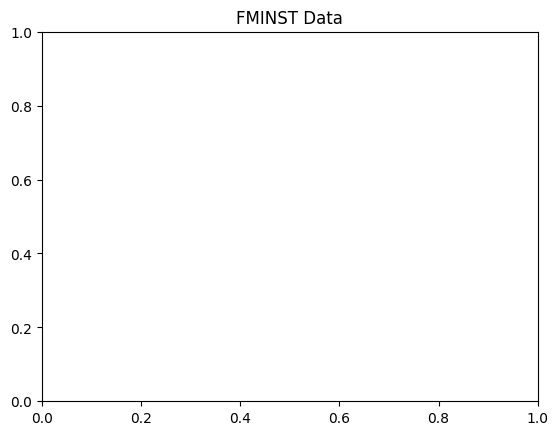

In [11]:
plt.title('FMINST Data')
plt.bar(data_info.keys(),data_info.values())
plt.xlabel('Class')
plt.ylabel('Num of Samples')
plt.xticks([i for i in range(len(np.unique(Y_fm)))]);

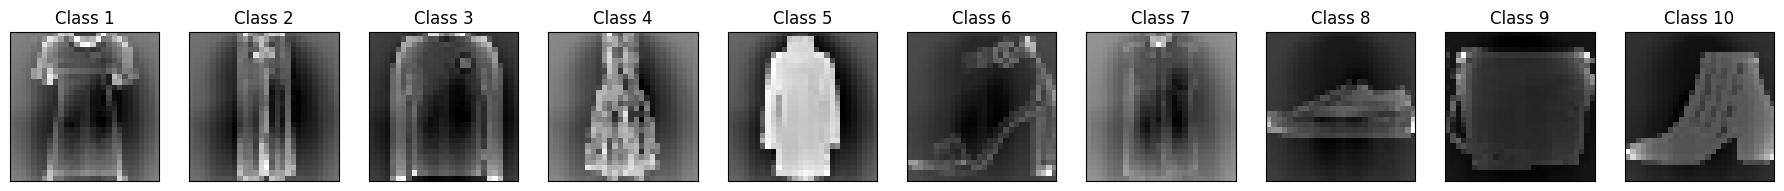

In [13]:
images_plot=[]
for i in range(len(np.unique(Y_fm))):
    images_plot.append(X_fm_scaled[Y_fm==i][0])
titles=[f'Class {i+1}' for i in range(len(np.unique(Y_fm)))]
plot_gallery(images_plot,titles, 28, 28,1,10)